In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("SPAM text message 20170820 - Data.csv")

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [5]:
df['length'] = df['Message'].apply(len)
df.head()

,Category,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<AxesSubplot:ylabel='Frequency'>

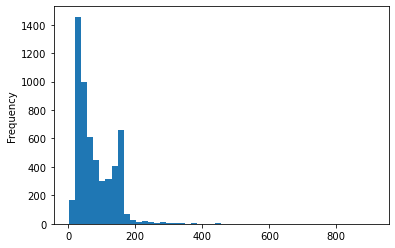

In [7]:
df['length'].plot(bins=50, kind='hist') 

In [8]:
df.length.describe()

count    5572.000000
mean       80.368988
std        59.926946
min         2.000000
25%        35.750000
50%        61.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

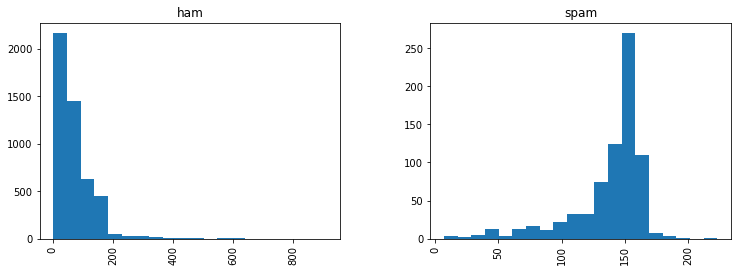

In [9]:
df.hist(column='length', by='Category', bins=20,figsize=(12,4))

In [10]:
from nltk.corpus import stopwords
import string
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [11]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    lemma = nlp.WordNetLemmatizer()
    nopunc = [ lemma.lemmatize(word) for word in nopunc]

In [12]:
df['Message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: Message, dtype: object

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['Message'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

11422


In [14]:
messages_bow = bow_transformer.transform(df['Message'])

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11422)


In [17]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = train_test_split(df['Message'], df['Category'], test_size=0.2, random_state = 42)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


In [18]:
msg_train.head()

1978    Reply to win £100 weekly! Where will the 2006 ...
3989    Hello. Sort of out in town already. That . So ...
3935     How come guoyang go n tell her? Then u told her?
4078    Hey sathya till now we dint meet not even a si...
4086    Orange brings you ringtones from all time Char...
Name: Message, dtype: object

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [20]:
from sklearn.neural_network import MLPClassifier
nn=MLPClassifier(random_state=1)

In [21]:
pipeline_nn = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MLPClassifier()),  # train on TF-IDF vectors w/ SVM
])

In [22]:
pipeline_nn.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000015EC3DA4EE8>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MLPClassifier())])

In [24]:
predictions_nn = pipeline_nn.predict(msg_test)

In [26]:
predictions_nn

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [27]:
print(classification_report(predictions_nn,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.99      0.99       976
        spam       0.92      0.99      0.95       139

    accuracy                           0.99      1115
   macro avg       0.96      0.99      0.97      1115
weighted avg       0.99      0.99      0.99      1115

